In [3]:
#import libraries
import pandas as pd
import numpy as np
import datetime

from sklearn.preprocessing import MinMaxScaler

#Clustering Packages
from sklearn.cluster import KMeans
#from kmodes.kmodes import KModes
#from kmodes.kprototypes import KPrototypes

from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
#from kneed import KneeLocator

#Plotting Packages
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

#Misc Packages
import copy 

import warnings
warnings.filterwarnings('ignore')

# Defined Functions

In [7]:
#Create a function for radar charts with go plots
def plot_radar(df):
    """
    Insert you dataframe, where clusters are the index
    
    This will loop through each cluster (index) and create distinct plots so you can better see the change over time.
    """
    
    data = []
    for i in range(0,len(df)):
        data.append(go.Scatterpolar(r=df.iloc[i].values, theta=df.iloc[i].index, 
                                    fill='toself', name = f'cluster_{df.index[i]}'))
        
        #mean line - if you want this, just delete the '#'
        #data.append(go.Scatterpolar(r=[100]*df.shape[1], theta=df.columns, fill='toself', name = 'Mean'))
        
        layout = go.Layout(polar = dict(radialaxis = dict(visible = True)),
                          showlegend = True)
        fig = go.Figure(data = data, layout = layout)
        fig.show()

#Radar plot with matplotlib
def radar_plot(data, cluster, title = "Clustering", save=False, cluster_map=False):
    """Creates a radar plot from inputed data and clustering model output
    data should be DataFrame and cluster an np.array
    
    title can be specified to set plot title or it will default to 'Clustering'
    
    save can be specified as a string in which case the image is saved to the path
    of that inputted string. If no string is specified the image will not be saved.
    
    cluster_map specifies how many of the identified clusters to draw. 
    Must be integer > 0
    """
    
    #concatinate clustering and data
    data_cluster = pd.concat([data,pd.DataFrame(cluster)], axis=1)
    data_cluster = data_cluster.rename(columns= {0: 'cluster'})
    #group by cluster with median and save to new frame
    clustered = data_cluster.groupby('cluster').median()
    #generate category labels
    categories = [*clustered.columns, clustered.columns[0]]

    #empty object for defining groups
    radar = []
    #define groups, last element must be first element to close radar group
    for i in range(len(clustered)):
        radar.append([*clustered.iloc[i], clustered.iloc[i, 0]])
    
    #label location for radar plot
    label_loc = np.linspace(start=0, stop=2 * np.pi, 
                            num=len(radar[0]))
    #color scheme
    colors = ['royalblue', 'orange','forestgreen', 'mediumpurple','deepskyblue', 'mediumspringgreen', 'hotpink']  
        #initiate plot
    plt.figure(figsize=(8,8))
    plt.subplot(polar = True)
    
    #if cluster map is defined
    if bool(cluster_map):
        cluster_map = cluster_map
    else:
        cluster_map = len(radar)
    
    #loop through every cluster
    for i in range(0,cluster_map):
        #if there are outliers (ex with DBSCAN) id them
        if clustered.index[i] < 0:
            plt.plot(label_loc, radar[i], label=f"Outliers", color='red')
        #else plot as cluster
        else: 
            plt.plot(label_loc, radar[i], label=f"Cluster {i}", color=colors[i])
    
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)

    plt.title(title)
    plt.legend()
    
    #if save path is defined save figure
    if bool(save):
        plt.savefig(save)
    #if not just show
    else:
        plt.show()

In [8]:
#define plot for KMeans elbow plot
def plot_distortion(df):
    """
    Plot the elbow plot for Kmeans
    
    df - Your dataframe or variables
    """
    #create plot
    plt.figure(figsize=(8, 6))
    
    #create empty list for criterion
    wcss = []
    
    #for loop through 1-14 are the number of potential clusters
    for i in range(1, 15):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_) #criterion based on which K-means clustering works
    
    #Finish plot
    plt.plot(range(1, 15), wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

#define function to plot KModes elbow curve
def kmode_optimal(df):
    """
    This function finds the Elbow curve to find optimal Kmodes
    
    Input your pandas dataframe
    """
    
    cost = []
    K = range(1,8)

    #run through K to find optimal n_clusters
    for num_clusters in list(K):
        kmode = KModes(n_clusters=num_clusters, init = "random", 
                       n_init = 5, verbose=1, random_state=42)
        kmode.fit_predict(df)
        cost.append(kmode.cost_)

    #Plot elbow plot
    plt.plot(K, cost, 'bx-')
    plt.xlabel('No. of clusters')
    plt.ylabel('Cost')
    plt.title('Elbow Method For Optimal k')
    plt.show()

#Define function for KMode Clustering
def kmode_clusters(df, n):
    """
    This function takes in your pandas dataframe and applies KModes clustering to give a plot as an output
    
    n - The number of clusters you want to apply
    """
    #Instantiate KModes
    kmodes = KModes(n_clusters = n, init = "random", n_init = 5, verbose=1, random_state=42)

    #Fit and predict to dataframe
    y_modes = kmodes.fit_predict(df)

    #princt centroids
    print(kmodes.cluster_centroids_)

    #for loop to create list from y_modes
    cluster_dic = []
    for c in y_modes:
        cluster_dic.append(c)

    #Create cluster column with list
    df['Cluster'] = cluster_dic

    #Create due dataframe with clusters as index and drop cluster column
    summary = round(df.groupby('Cluster').median(),1)
    
    #create radar plot
    plot = radar_plot(df, y_modes)
    
    return summary, plot
    
#create clusters for DBSCAN
def DBSCAN_cluster(a, eps):
    """
    Create clusters for DBSCAN
        a - the dataframe transposed
        eps - epsilon value
    """
    
    db = DBSCAN(eps, min_samples=2).fit(a)
    return db.labels_

# Data

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
#load dataframe
path = "/content/drive/MyDrive/mini/pre_c_crime_2.csv"
df = pd.read_csv(path)
df.head()

,ARREST_DATE,WeekDay,Month,Crime Severity,ARREST_BORO,ARREST_PRECINCT,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,New Georeferenced Column
0,2019-03-01,4,3,1,2,14,1,1,2,40.757578,-73.989545,POINT (-73.98954452399994 40.75757811200003)
1,2019-03-01,4,3,0,3,109,0,1,4,40.781417,-73.778168,POINT (-73.77816787699999 40.78141724100004)
2,2019-03-01,4,3,0,1,60,0,1,2,40.575574,-73.981204,POINT (-73.98120362499998 40.575573630000065)
3,2019-03-01,4,3,1,1,79,0,1,2,40.688378,-73.944912,POINT (-73.94491165999996 40.68837827800007)
4,2019-03-01,4,3,0,0,41,2,1,5,40.814684,-73.891918,POINT (-73.89191764199995 40.81468425600008)


In [22]:
#Drop columns
df_stand = df.drop(['New Georeferenced Column', 'ARREST_DATE', 'ARREST_PRECINCT'], axis = 1)

#Scale lat and long
col_names = ['Latitude', 'Longitude'] #list columns you want to scale
features = df[col_names]
scaler = MinMaxScaler().fit(features.values) #apply Standard scaler
features = scaler.transform(features.values) #transform

#replace values with scaled values
df_stand[col_names] = features 

#view new table
df_stand.head()

,WeekDay,Month,Crime Severity,ARREST_BORO,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude
0,4,3,1,2,1,1,2,0.627188,0.475794
1,4,3,0,3,0,1,4,0.685000,0.858869
2,4,3,0,1,0,1,2,0.185805,0.490911
3,4,3,1,1,0,1,2,0.459370,0.556682
4,4,3,0,0,2,1,5,0.765677,0.652722


# Clustering
In this file, instructions how to approach the challenge can be found.

We can use different types of clustering algorithms:

- KMeans
- Hierarchical
- DBScan

## Trial 1 - KMeans

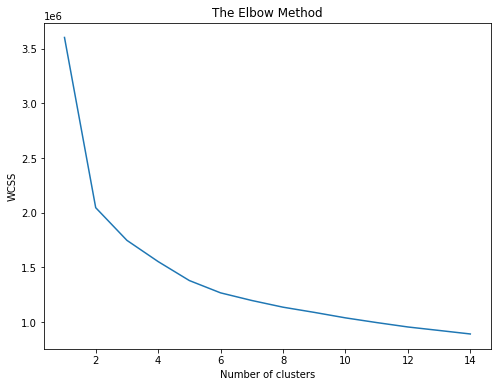

In [ ]:
#Elbow rule
plot_distortion(df_stand)

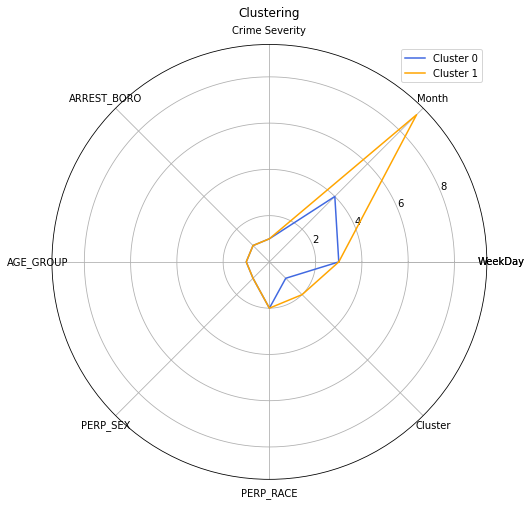

In [ ]:
#first check kmeans
km = KMeans(n_clusters=2, init = 'k-means++', random_state=0)

#fit and predict
y_kmeans = km.fit_predict(df_stand)

#begin clustering numbering with 1, not 0
y_kmeans1 = y_kmeans+1

#new list called cluster
cluster = list(y_kmeans1)

#Add cluster to data
df_stand['Cluster'] = cluster

#group by cluster
summary_means = round(df_stand.groupby('Cluster').median(),1)
summary_means

#save to csv
#summary_df2.to_csv('summary_df2.csv')

#plot radar
radar_plot(df_stand, y_kmeans1)

Above we have 2 different clusters. Some overlap is expected with crime data as it can be sporadic.

Cluster 0:

    The race and sex of the people in this cluster are black males between the ages of 25 and 44 in Brooklyn. The crimes they are arrested for are more mild and crimes typicailly occur on thursday. Crimes mainly happen in April.
    
Cluster 1:

    The race and sex of the people in this cluster are black males between the ages of 25 and 44 in Brooklyn. The crimes they are arrested for are more mild and crimes typicailly occur on thursday. Crimes mainly happen in September.
    
Overall this is not a good clustering.

## Trial 2 - KModes

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1164141.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 1164141.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 1164141.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 1164141.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 1164141.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 21167, cost: 1091153.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 86043, cost: 1127759.0
Run 2, iteration: 2/100, moves: 1025, cost: 1127759.0

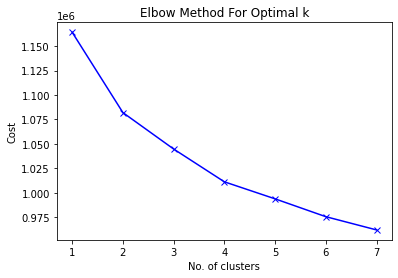

In [20]:
#delete cluster column, from previous trial
#df_stand = df_stand.drop('Cluster', axis = 1)

# Elbow curve to find optimal Kmodes
cost = []
K = range(1,8)

#run through K to find optimal n_clusters
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, 
                   verbose=1, random_state= 24)
    kmode.fit_predict(df_stand)
    cost.append(kmode.cost_)

#Plot elbow plot
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 53268, cost: 1011331.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 20219, cost: 1031615.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 16520, cost: 1015884.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 54242, cost: 1026301.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 39668, cost: 1021640.0
Best run was number 1
[[2.         6.         1.         2.         1.         1.
  2.         0.52719026 0.45457504]
 [1.         8.         0.         0.         1.         1.
  5.         0.75528348 0.59295727]
 [4.         4.         0.         3.         1.         0.
  5.         0.43900455 0.86237408]
 [4.         9.

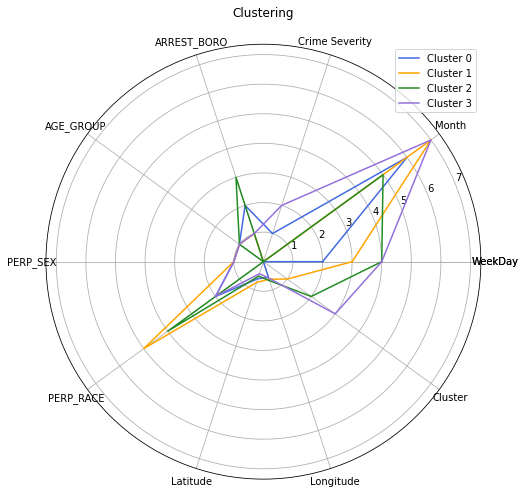

In [23]:
#Instantiate KModes
kmodes = KModes(n_clusters = 4, init = "random", n_init = 5, verbose=1, random_state=24)

#Fit and predict to dataframe
y_modes = kmodes.fit_predict(df_stand)

#princt centroids
print(kmodes.cluster_centroids_)

#for loop to create list from y_modes
cluster_dic = []
for c in y_modes:
    cluster_dic.append(c)

#Create cluster column with list
df_stand['Cluster'] = cluster_dic
df_stand.to_csv('/content/drive/MyDrive/mini/crime_clusters.csv')

#Create due dataframe with clusters as index
mode_stand = round(df_stand.groupby('Cluster').median(),1)

#create radar plot
radar_plot(df_stand, y_modes)

In [13]:
#Let's see the above broken down
plot_radar(mode_stand)

Above we have 4 different clusters. Some overlap is expected with crime data as it can be sporadic.

Cluster 0:

    The race and sex of the people in this cluster are black males between the ages 24 and 44 in Manhatten. The crimes they are arrested for are mild and crimes typicailly occur on Wednesdays. Crimes mainly happen in June.

Cluster 1:

    The race and sex of the people in this cluster are White hispanic males between the ages 25 and 44 in Brooklyn. The crimes they are arrested for are more minor and crimes typicailly occur on Thursday. Crimes mainly happen in July.

Cluster 2:

    The race and sex of the people in this cluster are white females between the ages 25 and 44 in Queens. The crimes they are arrested for are more minor and crimes typicailly occur on Fridays in the month of May.
    
Cluster 3:

    The race and sex of the people in this cluster are black males between the ages 24 and 44 Brooklyn. The crimes they are arrested for are more severe and crimes typicailly occur on Fridays. Crimes mainly happen in July.


These are better clusters

In [14]:
# view summar
mode_stand

,WeekDay,Month,Crime Severity,ARREST_BORO,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude
Cluster,,,,,,,,,
0,2.0,6.0,1.0,2.0,1.0,1.0,2.0,0.6,0.6
1,3.0,7.0,0.0,1.0,1.0,1.0,5.0,0.7,0.6
2,4.0,5.0,0.0,3.0,1.0,0.0,4.0,0.5,0.7
3,4.0,7.0,2.0,1.0,1.0,1.0,2.0,0.4,0.6


In [4]:
#Lets make a nicer chart

#labels
categories = ['Day', 'Month', 'Crime Severity','Borough', 
              'Age Group', 'Gender', 'Race']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=[2,6,1,2,1,1,2], theta=categories, 
                              fill ='tonext', name='Black Males Manhatten'))
fig.add_trace(go.Scatterpolar(r=[3,7,0,1,1,1,5], theta=categories, 
                              fill ='tonext', name='White Hispanic Males Brooklyn'))
fig.add_trace(go.Scatterpolar(r=[4,5,0,3,1,0,4], theta=categories, 
                              fill ='tonext', name='White Females Queens'))
fig.add_trace(go.Scatterpolar(r=[4,7,2,1,1,1,2], theta=categories, 
                              fill ='tonext', name='Black Males Brooklyn'))

fig.update_layout(
    polar = dict(
        radialaxis=dict(
            visible=True,
            range = [0,8])),
            showlegend=True,
            paper_bgcolor="white")

fig.show()

## Trial 3 - KPrototypes

In [15]:
#delete the cluster column
df_stand = df_stand.drop('Cluster', axis = 1)

#create empty lists
costs = []
n_clusters = []

#list columns that are categorical and range of n_clusters
cat_cols = [2, 3, 4, 5, 6]
K = range(1,6)

#create for loop to go through range of clusters for distortion plot
for i in list(K):
    try:
        kproto = KPrototypes(n_clusters=i, init='Huang', n_init = 5, verbose=2)
        clusters = kproto.fit_predict(df_stand, categorical=cat_cols)
        costs.append(kproto.cost_)
        n_clusters.append(i)
    except:
        print(f"Can't cluster with {i} clusters")

#Plot
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs))
fig.show()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 3460781.371706225
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 3460781.371706225
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 3460781.371706225
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 3460781.371706225
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 3460781.371706225
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 32891, ncost: 1977906.6225834605
Run: 1, iteration: 2/100, moves: 7926, ncost: 1960777.4148378945
Run: 1, iteration: 3/100, moves: 16585, ncost: 1905800.1814256

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 53268, cost: 1011331.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 20219, cost: 1031615.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 16520, cost: 1015884.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 54242, cost: 1026301.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 39668, cost: 1021640.0
Best run was number 1
[[2.         6.         1.         2.         1.         1.
  2.         0.52719026 0.45457504]
 [1.         8.         0.         0.         1.         1.
  5.         0.75528348 0.59295727]
 [4.         4.         0.         3.         1.         0.
  5.         0.43900455 0.86237408]
 [4.         9.

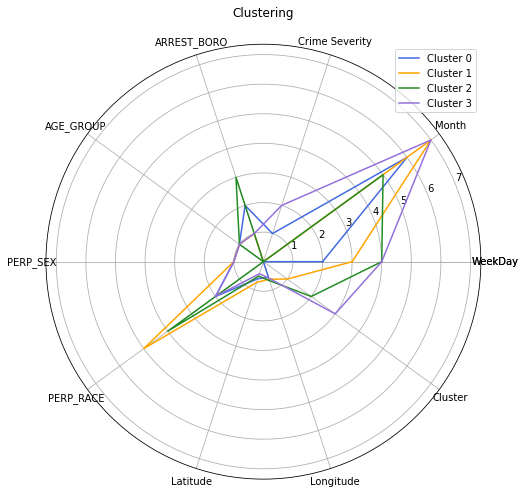

In [16]:
#Instantiate KModes
kproto = KPrototypes(n_clusters = 2, init='Huang', verbose=2, random_state=2)

#Fit and predict to dataframe
y_proto = kmodes.fit_predict(df_stand)

#print centroids
print(kmodes.cluster_centroids_)

#for loop to create list from y_modes
cluster_dic = []
for c in y_proto:
    cluster_dic.append(c)

#Create cluster column with list
df_stand['Cluster'] = cluster_dic
df_stand.to_csv('/content/drive/MyDrive/mini/crime_clusters_kproto.csv')

#group by cluster
summary_proto = round(df_stand.groupby('Cluster').median(),1)

#create radar plot
radar_plot(df_stand, y_proto)

In [17]:
#Let's see the above broken down
plot_radar(summary_proto)

Above we have 4 different clusters. Some overlap is expected with crime data as it can be sporadic.

Cluster 0:

    The race and sex of the people in this cluster are black males between the ages 24 and 44 in Manhatten. The crimes they are arrested for are mild and crimes typicailly occur on Wednesdays. Crimes mainly happen in June.

Cluster 1:

    The race and sex of the people in this cluster are White hispanic males between the ages 25 and 44 in Brooklyn. The crimes they are arrested for are more minor and crimes typicailly occur on Thursday. Crimes mainly happen in July.

Cluster 2:

    The race and sex of the people in this cluster are white females between the ages 25 and 44 in Queens. The crimes they are arrested for are more minor and crimes typicailly occur on Fridays in the month of May.
    
Cluster 3:

    The race and sex of the people in this cluster are black males between the ages 24 and 44 Brooklyn. The crimes they are arrested for are more severe and crimes typicailly occur on Fridays. Crimes mainly happen in July.


Overall, these are the same clusters as KModes. :)

## Trial 4 - DBSCAN

Text(0, 0.5, 'Distance')

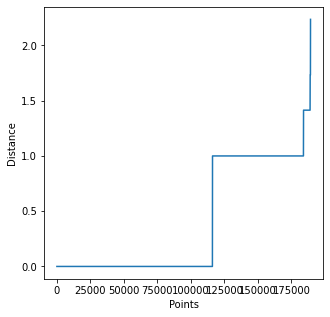

In [ ]:
#delete cluster column
#df_stand = df_stand.drop('Cluster', axis = 1)

#apply nearest neighbour to df_stand
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(df_stand)

#calculate neighbour distances
distances, indices = neighbors.kneighbors(df_stand)
distances = np.sort(distances[:,10], axis=0)

#plot figure
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

1.0


<Figure size 360x360 with 0 Axes>

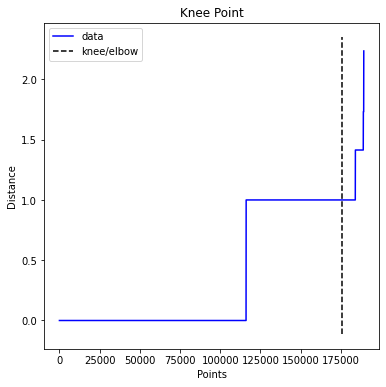

In [ ]:
#Find the best fit episilon value for DBSCAN, use previous distances that was calculated
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

#Plot figure
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

#Best episilon
print(distances[knee.knee]) 

In [ ]:
#run DBSCAN function with best epsilon
lbl = DBSCAN_cluster(df_stand.T,1.09794)

#list clusters
idx = np.unique(lbl) 

#Add clusters to dataframe
res = pd.concat([df_stand.iloc[:,lbl==i] for i in idx],keys=idx)

DBSCANS IS NOT GOOD!!!!!! This will only end in your computer crashing when you plot the clusters - WAY TOO MANY CLUSTERS

# Segmentation of NYC Boroughs

I am going to try and further segment the data into boroughs and then apply clustering to them

In [54]:
#deepcopy
df2 = copy.deepcopy(df)

#Drop Geo column
df2 = df2.drop(['New Georeferenced Column', 'ARREST_DATE'], axis = 1)

#Scale lat and long
col_names = ['Latitude', 'Longitude'] #list columns you want to scale
features = df2[col_names]
scaler = MinMaxScaler().fit(features.values) #apply Min Max scaler
features = scaler.transform(features.values) #transform

df2[col_names] = features #replace values with scaled values

In [55]:
#Create dataframes per borough
Bronx = df2[df2['ARREST_BORO'] == 0]
Brooklyn = df2[df2['ARREST_BORO'] == 1]
Manhatten = df2[df2['ARREST_BORO'] == 2]
Queens = df2[df2['ARREST_BORO'] == 3]
Staten = df2[df2['ARREST_BORO'] == 4]

#print list of precincts in each borough
print("Bronx Precincts:", sorted(Bronx['ARREST_PRECINCT'].unique().tolist()))
print("Brooklyn Precincts:", sorted(Brooklyn['ARREST_PRECINCT'].unique().tolist()))
print("Manhatten Precincts:", sorted(Queens['ARREST_PRECINCT'].unique().tolist()))
print("Queens Precincts:", sorted(Manhatten['ARREST_PRECINCT'].unique().tolist()))
print("Staten Island Precincts:", sorted(Staten['ARREST_PRECINCT'].unique().tolist()))

Bronx Precincts: [10, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52]
Brooklyn Precincts: [60, 61, 62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 81, 83, 84, 88, 90, 94, 106]
Manhatten Precincts: [83, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
Queens Precincts: [1, 5, 6, 7, 9, 10, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 109, 114]
Staten Island Precincts: [120, 121, 122, 123]


In [56]:
#Drop Arrest borough col and sort index
Bronx = Bronx.drop(['ARREST_BORO', 'ARREST_PRECINCT'], axis =1).reset_index(drop=True)
Brooklyn = Brooklyn.drop(['ARREST_BORO', 'ARREST_PRECINCT'], axis =1).reset_index(drop=True)
Manhatten = Manhatten.drop(['ARREST_BORO','ARREST_PRECINCT'], axis =1).reset_index(drop=True)
Queens = Queens.drop(['ARREST_BORO', 'ARREST_PRECINCT'], axis =1).reset_index(drop=True)
Staten = Staten.drop(['ARREST_BORO', 'ARREST_PRECINCT'], axis =1).reset_index(drop=True)

#print dateframes shapes
print("Bronx shape:", Bronx.shape)
print("Brooklyn shape:", Brooklyn.shape)
print("Manhatten shape:", Manhatten.shape)
print("Queens shape:", Queens.shape)
print("Staten Island shape:", Staten.shape)

Bronx shape: (43058, 8)
Brooklyn shape: (51966, 8)
Manhatten shape: (46642, 8)
Queens shape: (39659, 8)
Staten Island shape: (7983, 8)


### Modeling

Use different attributes and clustering techniques and compare the created clusters:

- clustering only on restaurant features
- clustering only on Uber features
- clustering only on location
- combination of all

**Questions:**
1. Which clustering is the best?
2. How are neighborhoods split when we select only 2 clusters?
3. Are there any differences in housing and rental costs in different clusters?

### Bronx

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 236679.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 236679.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 236679.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 236679.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 236679.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11871, cost: 215828.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1348, cost: 222206.0
Init: initializing centroids
Init: initializing clusters
Star

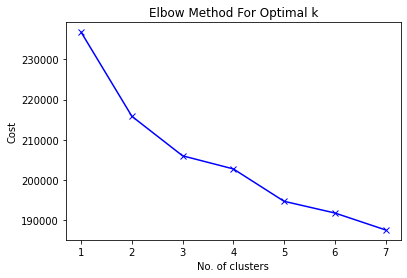

In [49]:
#Compute elbow plot for Bronx
kmode_optimal(Bronx)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11871, cost: 215828.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1348, cost: 222206.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1175, cost: 218940.0
Run 3, iteration: 2/100, moves: 9416, cost: 218940.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 9423, cost: 217429.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 3833, cost: 224690.0
Best run was number 1
[[3.         7.         0.         1.         1.         5.
  0.75528348 0.59295727]
 [2.         3.         1.         1.         1.         2.
  0.94185857 0.73367267]]


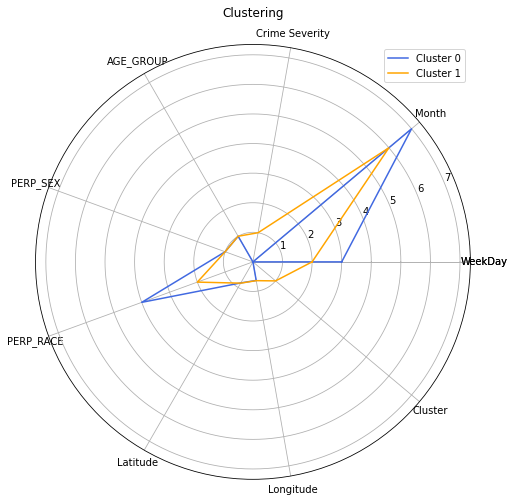

In [50]:
#Plot clusters for the Bronx
summary, plot = kmode_clusters(Bronx, 3)
plot

In [51]:
#Let's see the above broken down
plot_radar(summary)

Above we have 2 different clusters. Some overlap is expected with crime data as it can be sporadic.

Cluster 0:

    The race and sex of the people in this cluster are white males between the ages 25 and 44. The crimes they are arrested for are more minor and crimes typicailly occur on Thursdays and more in the month of July.
    
Cluster 1:

    The race and sex of the people in this cluster are black males between the ages 25 and 44. The crimes they are arrested for are more severe and crimes typicailly occur on Wednesdays. Crimes mainly happen in June.
    


### Brooklyn

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 272379.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 272379.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 272379.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 272379.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 272379.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3933, cost: 254919.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 5627, cost: 261025.0
Init: initializing centroids
Init: initializing clusters
Start

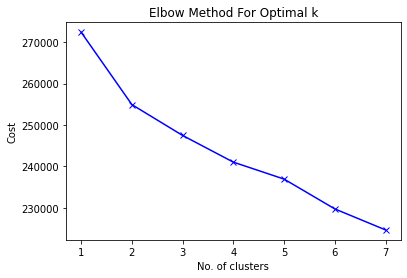

In [59]:
#Compute elbow plot for Brooklyn
kmode_optimal(Brooklyn)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 771, cost: 270201.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 6028, cost: 286824.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 13461, cost: 287066.0
Run 3, iteration: 2/100, moves: 529, cost: 287066.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1030, cost: 287078.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1732, cost: 287349.0
Best run was number 1
[[2.         6.         0.         1.         1.         2.
  0.41822351 0.67158069 0.        ]
 [1.         3.         2.         1.         1.         2.
  0.41749396 0.61349399 1.        ]]


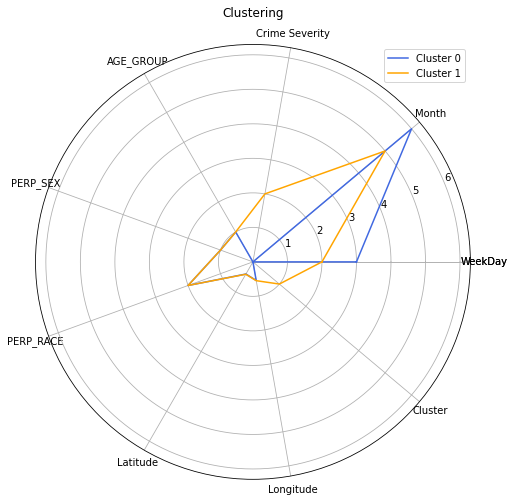

In [61]:
#plot clusters for Brooklyn
summary, plot = kmode_clusters(Brooklyn, 2)
plot

In [62]:
#Let's see the above broken down
plot_radar(summary)

Above we have 2 different clusters. Some overlap is expected with crime data as it can be sporadic.

Cluster 0:

    The race and sex of the people in this cluster are black males between the ages 25 and 44. The crimes they are arrested for are minor crimes. Crimes typicailly occur on Thursdays and more in the month of June.
    
Cluster 1:

    The race and sex of the people in this cluster are black males between the ages 25 and 44. The crimes they are arrested for are severe and crimes typicailly occur on Wednesdays. Crimes mainly happen in May.



### Manhatten

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 251180.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 251180.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 251180.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 251180.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 251180.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4837, cost: 238220.0
Run 1, iteration: 2/100, moves: 183, cost: 238220.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 9381, cost: 232398.0
Run 2, ite

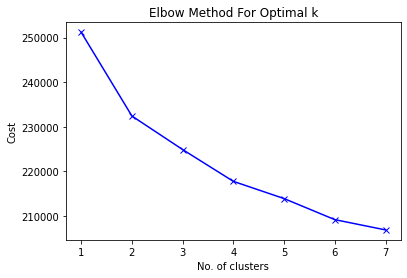

In [63]:
#Compute elbow plot for Manhatten
kmode_optimal(Manhatten)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4837, cost: 238220.0
Run 1, iteration: 2/100, moves: 183, cost: 238220.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 9381, cost: 232398.0
Run 2, iteration: 2/100, moves: 1150, cost: 232398.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 7945, cost: 233270.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 6059, cost: 235094.0
Run 4, iteration: 2/100, moves: 128, cost: 235094.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 4329, cost: 233119.0
Best run was number 2
[[ 3.          4.          1.          1.          1.          2.
   0.64615053  0.48275775]
 [ 2.         11.          0.          1.          1.          

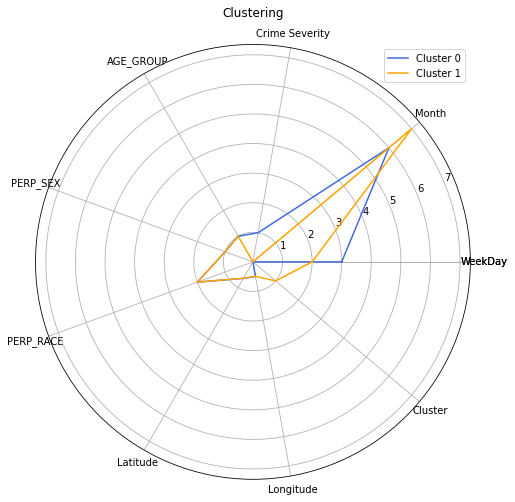

In [64]:
#Plot Clusters for Manhatten
summary, plot = kmode_clusters(Manhatten, 2)
plot

In [65]:
#Let's see the above broken down
plot_radar(summary)

Above we have 2 different clusters. Some overlap is expected with crime data as it can be sporadic.

Cluster 0:

    The race and sex of the people in this cluster are black males between the ages 25 and 44. The crimes they are arrested for are mild crimes, and crimes typicailly occur on Thursdays and more in the month of June.
    
Cluster 1:

    The race and sex of the people in this cluster are black males between the ages 25 and 44. The crimes they are arrested for are more minor and crimes typicailly occur on Wednesdays. Crimes mainly happen in July.

### Queens

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 215118.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 215118.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 215118.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 215118.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 215118.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11690, cost: 200356.0
Run 1, iteration: 2/100, moves: 916, cost: 200356.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 5741, cost: 203467.0
Run 2, it

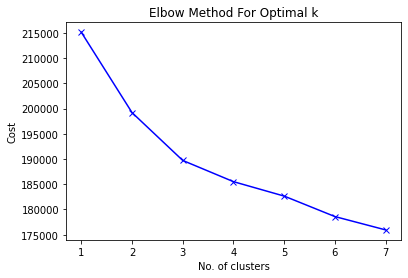

In [66]:
#Compute elbow plot for Queens
kmode_optimal(Queens)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10550, cost: 194565.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 12519, cost: 192648.0
Run 2, iteration: 2/100, moves: 3186, cost: 192648.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 4973, cost: 192519.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 3781, cost: 201421.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 5864, cost: 189708.0
Best run was number 5
[[3.         6.         1.         0.         1.         2.
  0.43916943 0.86296255]
 [2.         7.         0.         1.         1.         5.
  0.43900455 0.86237408]
 [0.         8.         2.         1.         1.         2.
  0.43916943 0.86296255]]


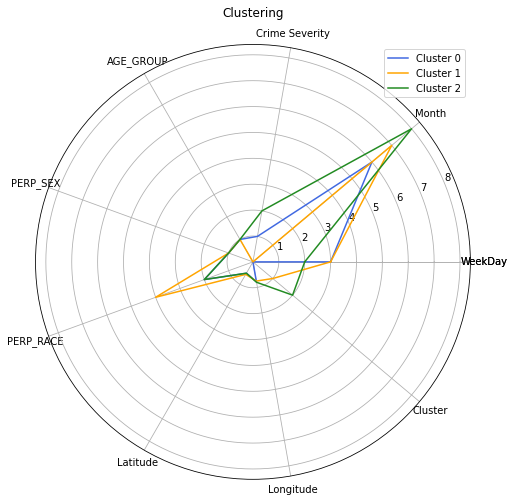

In [67]:
#Plot clusters for Staten
summary, plot = kmode_clusters(Queens, 3)
plot

In [68]:
#Let's see the above broken down
plot_radar(summary)

Above we have 3 different clusters. Some overlap is expected with crime data as it can be sporadic.

Cluster 0:

    The race and sex of the people in this cluster are black males between the ages 18 and 24. The crimes they are arrested for are mild crimes, and crimes typicailly occur on Thursdays in the month of June.
    
Cluster 1:

    The race and sex of the people in this cluster are white males between the ages 25 and 44. The crimes they are arrested for are minor crimes and crimes typicailly occur on Thursdays and in July.

Cluster 3:

    The race and sex of the people in this cluster are black males between the ages 25 and 44. The crimes they are arrested for are more severe and crimes typicailly occur on Wednessdays and in the month of August.


### Staten Island

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 42082.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 42082.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 42082.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 42082.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 42082.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1662, cost: 38669.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2029, cost: 38890.0
Init: initializing centroids
Init: initializing clusters
Starting ite

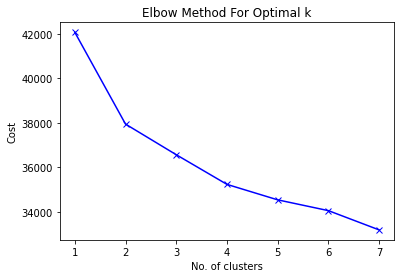

In [69]:
#Compute elbow plot for Staten Island
kmode_optimal(Staten)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1662, cost: 38669.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2029, cost: 38890.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2316, cost: 38709.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1660, cost: 37945.0
Run 4, iteration: 2/100, moves: 1248, cost: 37945.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 25, cost: 39795.0
Best run was number 4
[[1.         7.         1.         1.         1.         2.
  0.3013694  0.18640441]
 [2.         3.         0.         1.         1.         4.
  0.35422717 0.31690726]]


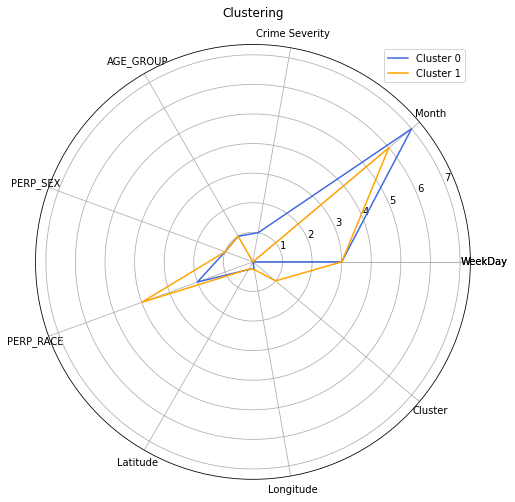

In [70]:
#Plot clusters for Staten
summary, plot = kmode_clusters(Staten, 2)
plot

In [71]:
#Let's see the above broken down
plot_radar(summary)

Above we have 2 different clusters. Some overlap is expected with crime data as it can be sporadic.

Cluster 0:

    The race and sex of the people in this cluster are balck males between the ages 25 and 44. The crimes they are arrested for are mild, and crimes typicailly occur on Thursdays and more in the month of July.
    
Cluster 1:

    The race and sex of the people in this cluster are white males between the ages 25 and 44. The crimes they are arrested for are more minor and crimes typicailly occur on Thursdays and in the month of June.
    

# Further reduction

During EDA, in pre-covid and covid there were precincts that still had the most crimes. I will look more closely on several of them. One per Borough.

In [74]:
#deepcopy
precincts = copy.deepcopy(df)

#Drop Geo column
precincts = precincts.drop(['New Georeferenced Column', 'ARREST_DATE', 'ARREST_BORO'], axis = 1)

#Scale lat and long
col_names = ['Latitude', 'Longitude'] #list columns you want to scale
features = precincts[col_names]
scaler = MinMaxScaler().fit(features.values) #apply Min Max scaler
features = scaler.transform(features.values) #transform

precincts[col_names] = features #replace values with scaled values

precincts.head()

,WeekDay,Month,Crime Severity,ARREST_PRECINCT,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude
0,4,3,1,14,1,1,2,0.627188,0.475794
1,4,3,0,109,0,1,4,0.685000,0.858869
2,4,3,0,60,0,1,2,0.185805,0.490911
3,4,3,1,79,0,1,2,0.459370,0.556682
4,4,3,0,41,2,1,5,0.765677,0.652722


In [75]:
#Create dataframes for 5 precincts
pre_40 = precincts[precincts['ARREST_PRECINCT'] == 40] #Bronx
pre_75 = precincts[precincts['ARREST_PRECINCT'] == 75] #Brooklyn
pre_14 = precincts[precincts['ARREST_PRECINCT'] == 14] #Manhatten
pre_113 = precincts[precincts['ARREST_PRECINCT'] == 113] #Queens
pre_120 = precincts[precincts['ARREST_PRECINCT'] == 120] #Staten Island

#Drop Arrest precinct and sort index
pre_40 = pre_40.drop(['ARREST_PRECINCT'], axis =1).reset_index(drop=True)
pre_75 = pre_75.drop(['ARREST_PRECINCT'], axis =1).reset_index(drop=True)
pre_14 = pre_14.drop(['ARREST_PRECINCT'], axis =1).reset_index(drop=True)
pre_113 = pre_113.drop(['ARREST_PRECINCT'], axis =1).reset_index(drop=True)
pre_120 = pre_120.drop(['ARREST_PRECINCT'], axis =1).reset_index(drop=True)

#print dateframes shapes
print("Precinct 40 shape:", pre_40.shape)
print("Precinct 75 shape:", pre_75.shape)
print("Precinct 14 shape:", pre_14.shape)
print("Precinct 113 shape:", pre_113.shape)
print("Precinct 120 shape:", pre_120.shape)

Precinct 40 shape: (6379, 8)
Precinct 75 shape: (5411, 8)
Precinct 14 shape: (5068, 8)
Precinct 113 shape: (5385, 8)
Precinct 120 shape: (3169, 8)


A quick test run showed that Kmeans and Kmodes gave the same number of clusters, I will just stick with KModes

## Precinct 40 - Bronx

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 32677.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 32677.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 32677.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 32677.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 32677.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1883, cost: 29375.0
Run 1, iteration: 2/100, moves: 258, cost: 29375.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 906, cost: 29988.0
Init: initializing 

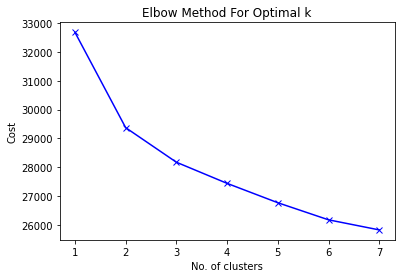

In [76]:
#Compute elbow plot for precinct 40
kmode_optimal(pre_40)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1883, cost: 29375.0
Run 1, iteration: 2/100, moves: 258, cost: 29375.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 906, cost: 29988.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1517, cost: 29748.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1076, cost: 29478.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 374, cost: 29406.0
Best run was number 1
[[3.         7.         2.         1.         1.         2.
  0.75528348 0.59295727]
 [1.         8.         1.         1.         1.         5.
  0.75528348 0.59295727]]


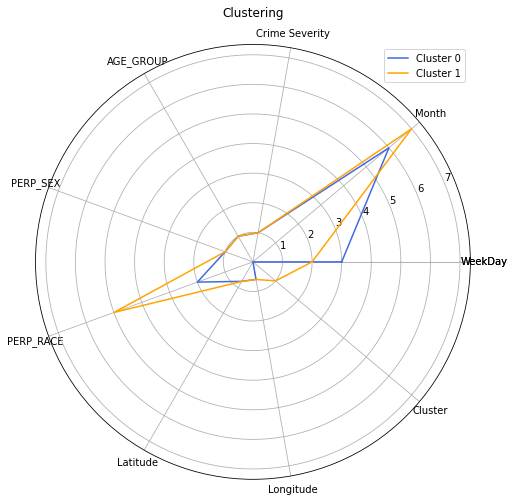

In [77]:
#Plot clusters for precinct 40
summary, plot = kmode_clusters(pre_40, 2)
plot

Above we have 2 different clusters. Some overlap is expected with crime data as it can be sporadic.

Cluster 0:

    The race and sex of the people in this cluster are black males between the ages 25 and 44. The crimes they are arrested for are mild, and crimes typicailly occur on Thursdays during the month of June.
    
Cluster 1:

    The race and sex of the people in this cluster are white hispanic males between the ages 25 and 44. The crimes they are arrested for are mild and crimes typicailly occur on Thursdays and in the month of July.


## Precinct 75 - Brooklyn

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 25512.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 25512.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 25512.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 25512.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 25512.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1564, cost: 23965.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 23791.0
Init: initializing centroids
Init: initializing clusters
Starting iterat

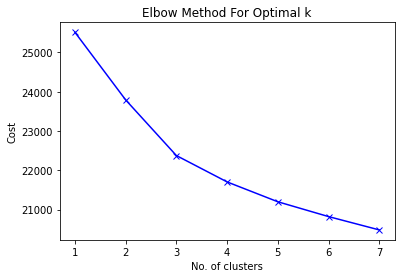

In [78]:
#Compute elbow plot for precinct 75
kmode_optimal(pre_75)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1803, cost: 22724.0
Run 1, iteration: 2/100, moves: 113, cost: 22724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 362, cost: 22492.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1202, cost: 22909.0
Run 3, iteration: 2/100, moves: 151, cost: 22909.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2166, cost: 22375.0
Run 4, iteration: 2/100, moves: 140, cost: 22375.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 977, cost: 23562.0
Best run was number 4
[[3.         5.         0.         0.         1.         2.
  0.41822351 0.67158069]
 [1.         8.         1.         1.         1.         2.
  0.37042252 0.6952581

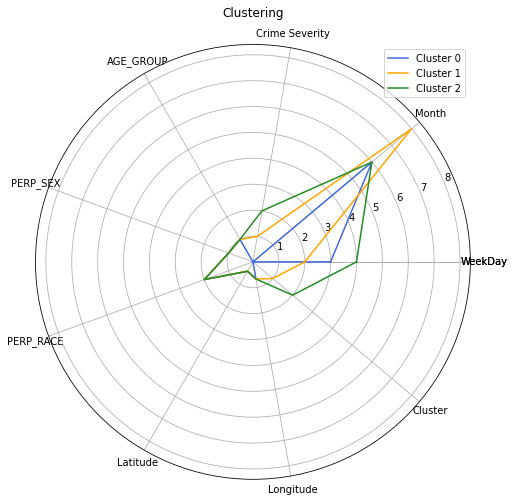

In [79]:
#Plot clusters for precinct 75
summary, plot = kmode_clusters(pre_75, 3)
plot

In [80]:
#Let's see the above broken down
plot_radar(summary)

Above we have 3 different clusters. Some overlap is expected with crime data as it can be sporadic.

Cluster 0:

    The race and sex of the people in this cluster are black males between the ages 25 and 44. The crimes they are arrested for are minor, and crimes typicailly occur on Thursdays during the month of June.
    
Cluster 1:

    The race and sex of the people in this cluster are black males between the ages 24 to 44. The crimes they are arrested for are milde and crimes typicailly occur on Wednesdays and in the month of August.

Cluster 2:

    The race and sex of the people in this cluster are black males between the ages 24 to 44. The crimes they are arrested for are severe and crimes typicailly occur on Fridays and in the month of June.

## Precinct 14 - Manhatten

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 25267.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 25267.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 25267.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 25267.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 25267.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 164, cost: 23067.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 63, cost: 24523.0
Init: initializing centroids
Init: initializing clusters
Starting iterat

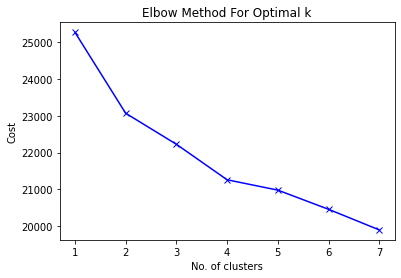

In [81]:
#Compute elbow plot for precinct 14
kmode_optimal(pre_14)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 164, cost: 23067.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 63, cost: 24523.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 100, cost: 24240.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 492, cost: 23818.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 591, cost: 23419.0
Best run was number 1
[[ 3.          8.          0.          1.          1.          2.
   0.60985445  0.47626993]
 [ 2.         10.          1.          1.          1.          2.
   0.6240061   0.47406063]]


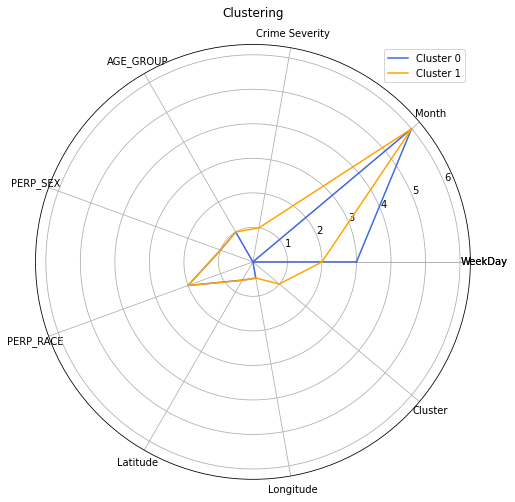

In [85]:
#Plot clusters for precinct 14
summary, plot = kmode_clusters(pre_14, 2)
plot

Above we have 2 different clusters. Some overlap is expected with crime data as it can be sporadic.

Cluster 0:

    The race and sex of the people in this cluster are black males between the ages 25 and 44. The crimes they are arrested for are minor, and crimes typicailly occur on Thursdays during the month of June.
    
Cluster 1:

    The race and sex of the people in this cluster are black males between the ages 25 and 44. The crimes they are arrested for are mild and crimes typicailly occur on Wednesdays and in the month of June

## Precinct 113 - Queens

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 24543.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 24543.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 24543.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 24543.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 24543.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 936, cost: 21844.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 259, cost: 22920.0
Init: initializing centroids
Init: initializing clusters
Starting itera

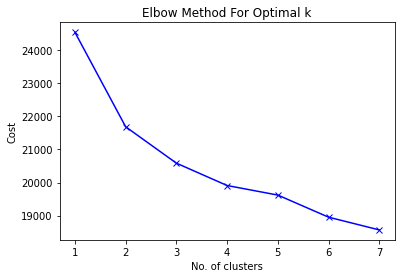

In [86]:
#Compute elbow plot for precinct 113
kmode_optimal(pre_113)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 936, cost: 21844.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 259, cost: 22920.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1086, cost: 21831.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 890, cost: 21902.0
Run 4, iteration: 2/100, moves: 13, cost: 21902.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1032, cost: 21686.0
Best run was number 5
[[2.         3.         0.         1.         1.         2.
  0.43900455 0.86237408]
 [4.         5.         2.         1.         1.         2.
  0.43916943 0.86296255]]


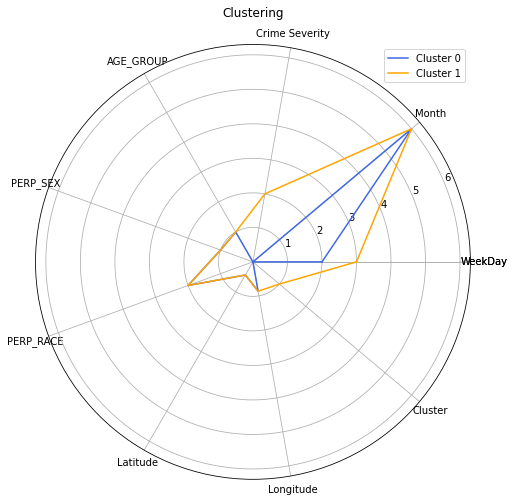

In [87]:
#Plot clusters for precinct 113
summary, plot = kmode_clusters(pre_113, 2)
plot

In [88]:
#Let's see the above broken down
plot_radar(summary)

Above we have 2 different clusters. Some overlap is expected with crime data as it can be sporadic.

Cluster 0:

    The race and sex of the people in this cluster are black males between the ages 25 and 44. The crimes they are arrested for are minor, and crimes typicailly occur on Wednesdays during the month of June.
    
Cluster 1:

    The race and sex of the people in this cluster are black males between the ages 25 and 44. The crimes they are arrested for are severe and crimes typicailly occur on Thursdays and in the month of June.
    

## Precinct 120 - Staten Island

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 15133.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 15133.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 15133.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 15133.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 15133.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 507, cost: 14183.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 736, cost: 14004.0
Init: initializing centroids
Init: initializing clusters
Starting itera

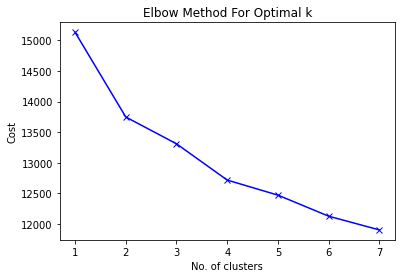

In [89]:
#Compute elbow plot for precinct 120
kmode_optimal(pre_120)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 507, cost: 14183.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 736, cost: 14004.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1165, cost: 13906.0
Run 3, iteration: 2/100, moves: 745, cost: 13749.0
Run 3, iteration: 3/100, moves: 55, cost: 13749.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 864, cost: 13977.0
Run 4, iteration: 2/100, moves: 39, cost: 13977.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 545, cost: 14169.0
Best run was number 3
[[3.         7.         1.         1.         1.         2.
  0.35422717 0.31690726]
 [1.         3.         0.         1.         1.         2.
  0.35422717 0.31690726]]


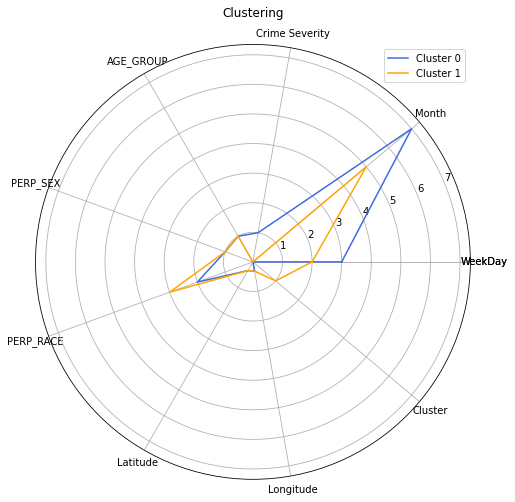

In [90]:
#Plot clusters for precinct 120
summary, plot = kmode_clusters(pre_120, 2)
plot

In [91]:
#Let's see the above broken down
plot_radar(summary)

Above we have 2 different clusters. Some overlap is expected with crime data as it can be sporadic.

Cluster 0:

    The race and sex of the people in this cluster are black males between the ages 25 and 44. The crimes they are arrested for are mild, and crimes typicailly occur on Thursdays during the month of July.
    
Cluster 1:

    The race and sex of the people in this cluster are black hispanic males between the ages 25 and 44. The crimes they are arrested for are minor and crimes typicailly occur on Wednesdays and in the month of May.

    

# Feature Selection / Dimensionality Reduction¶

We need to apply different selection techniques to find out which one will be the best for our problems.
Original Features vs. PCA conponents?
Don't forget to scale the features for KMeans.

We have so few features, that demensionality reduction does not make sense

# Evaluation

1. Check the segmentation evaluation metrics:
    - inertia
    - silhoutte score
2. How did you come up with the correct number of clusters?
3. Is there any relationship between the clusters and economic indicators? If yes, what does it mean?

You are required to share the file containing all NYC neighborhoods together with cluster_id with LighthouseLabs.

### Silhoutte Score

In [52]:
#import libraries
from sklearn.metrics import silhouette_score, silhouette_samples

#Create for loop for range of clusters
for n_clusters in range(2,8):
    # Initialize the clusterer with n_clusters value and a random generator seed for reproducibility.
    clusterer = KModes(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Bronx)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(Bronx, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.05283754247640174
For n_clusters = 3 The average silhouette_score is : 0.014691546030762103
For n_clusters = 4 The average silhouette_score is : -0.010911659466854266
For n_clusters = 5 The average silhouette_score is : -0.015123911424743893
For n_clusters = 6 The average silhouette_score is : -0.017568845322724406
For n_clusters = 7 The average silhouette_score is : -0.023323135407369907


Above based on the score and using the Bronx dataset as an example, you can see I chose the correct number of clusters, ie. 2.

In [58]:
#import libraries
from sklearn.metrics import silhouette_score, silhouette_samples

#Create for loop for range of clusters
for n_clusters in range(2,7):
    # Initialize the clusterer with n_clusters value and a random generator seed for reproducibility.
    clusterer = KModes(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Brooklyn)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(Brooklyn, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : -0.009338032193018441
For n_clusters = 3 The average silhouette_score is : -0.022290380046378636
For n_clusters = 4 The average silhouette_score is : -0.0231382271489339
For n_clusters = 5 The average silhouette_score is : -0.05518608313943504
For n_clusters = 6 The average silhouette_score is : -0.05083001350003925


Again the data needs further preparation, maybe need to look for other data than just the arrest data for proper binning, etc. I put 5 originally for Brooklyn which was not the best, but still not great

In [16]:
from sklearn.metrics import silhouette_score, silhouette_samples
#Create for loop for range of clusters
for n_clusters in range(3,6):
    # Initialize the clusterer with n_clusters value and a random generator seed for reproducibility.
    clusterer = KModes(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_stand)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_stand, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.01387425575374745
For n_clusters = 4 The average silhouette_score is : 0.020749820569126002
For n_clusters = 5 The average silhouette_score is : 0.004654080373920691


Above based on the score and using the standard full dataset. This says 4 clusters is best. However, we got 5 distinct clusters. The elbow chart was fairly smooth, so it is possible that more data prep is needed, or it was too many rows of data. Otherwise it is difficult to assume how many clusters is best.

In [84]:
#Create for loop for range of clusters
for n_clusters in range(2,7):
    # Initialize the clusterer with n_clusters value and a random generator seed for reproducibility.
    clusterer = KModes(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(pre_14)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(pre_14, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)



For n_clusters = 2 The average silhouette_score is : 0.006547685979709981
For n_clusters = 3 The average silhouette_score is : -0.0022885320766239683
For n_clusters = 4 The average silhouette_score is : -0.03380593372018347
For n_clusters = 5 The average silhouette_score is : -0.056699738174934865
For n_clusters = 6 The average silhouette_score is : -0.05861561956149882


I put the right number of clusters, but again the elbow plot was fairly smooth

# Creating dataframe for mapping from cluster data

In [38]:
#first retrieve the original lat and long
variables = df[['Latitude','Longitude']]
variables #turn into array

,Latitude,Longitude
0,40.757578,-73.989545
1,40.781417,-73.778168
2,40.575574,-73.981204
3,40.688378,-73.944912
4,40.814684,-73.891918
...,...,...
189303,40.758570,-73.877386
189304,40.817218,-73.953472
189305,40.657675,-74.000924
189306,40.641755,-73.999468


In [36]:
#upload cluster Kmode dataframe
path= '/content/drive/MyDrive/mini/crime_clusters.csv'
df_cluster = pd.read_csv(path)
df_cluster.head()

,Unnamed: 0,WeekDay,Month,Crime Severity,ARREST_BORO,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,Cluster
0,0,4,3,1,2,1,1,2,0.627188,0.475794,0
1,1,4,3,0,3,0,1,4,0.685000,0.858869,2
2,2,4,3,0,1,0,1,2,0.185805,0.490911,3
3,3,4,3,1,1,0,1,2,0.459370,0.556682,3
4,4,4,3,0,0,2,1,5,0.765677,0.652722,1


In [37]:
#oops drop index and lat and long
df_cluster = df_cluster.drop(['Unnamed: 0', 'Latitude', 'Longitude'], axis=1)

In [44]:
new_cluster = pd.merge(variables, df_cluster, left_index=True,right_index=True)
new_cluster.head()

,Latitude,Longitude,WeekDay,Month,Crime Severity,ARREST_BORO,AGE_GROUP,PERP_SEX,PERP_RACE,Cluster
0,40.757578,-73.989545,4,3,1,2,1,1,2,0
1,40.781417,-73.778168,4,3,0,3,0,1,4,2
2,40.575574,-73.981204,4,3,0,1,0,1,2,3
3,40.688378,-73.944912,4,3,1,1,0,1,2,3
4,40.814684,-73.891918,4,3,0,0,2,1,5,1


In [45]:
new_cluster.to_csv('/content/drive/MyDrive/mini/crime_clusters_new.csv')